# Generate windstress forcing for MOM6

In [7]:
import numpy as np
from netCDF4 import Dataset
import xarray as xr
from matplotlib import pyplot as plt

In [10]:
# Specify geometry of horizontal grid
# (based on MOM6 input parameters)

# Latitude and longitude
SOUTHLAT=-60.0
LENLAT=40.0
WESTLON=0.0
LENLON=60.0

# Number of grid cells
NI=int(LENLON*4)
NJ=int(LENLAT*4)

# Grid point positions (tracer point)
X=np.linspace(WESTLON,WESTLON+LENLON,NI+1)
X1d=(X[1:] + X[:-1]) / 2
Y=np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,NJ+1)
Y1d=(Y[1:] + Y[:-1]) / 2
# 2D mesh of grid point positions
X,Y=np.meshgrid(X1d,Y1d)
# Define lat and lon dimensions set to zero at the midpoint
X0 = xr.DataArray(np.linspace(-NI/2,NI/2,NI),coords=[X1d],dims='lon')
Y0 = xr.DataArray(np.linspace(-NJ/2,NJ/2,NJ),coords=[Y1d],dims='lat')
# Define xarray data array with dimensions of horizontal grid
# (for broadcasting dimensions of other variables later in the notebook)
hgrid = xr.DataArray(np.ones([NI,NJ]),coords=[X1d,Y1d],dims=['lon','lat'])

In [11]:
print(Y.shape)
print(X.shape)

(160, 240)
(160, 240)


In [12]:
# Define windstress on grid
taux_ref=0.2
tauy_ref=0.0

# Uniform
taux=taux_ref*np.ones(Y.shape)
tauy=tauy_ref*np.ones(Y.shape)

In [17]:
# ___ LATITUDINAL PROFILE ___ #
taux_ref = 0.2
tauy_ref = 0.0
zero_at_sponge = False

# Cosine bell
def cosbell(x):
    a0 = 0.5
    return a0+(1-a0)*np.cos((2*np.pi*x)/x.size)

# Gaussian
middle = SOUTHLAT+LENLAT/2
width = LENLAT/6
def gaussian(x, middle, width):
   return np.exp(-np.power(x - middle, 2.) / (2 * np.power(width, 2.)))

# Squared sinusoid (from Thompson and Hogg, 2017, JPO)
eastwestdivide = -50
taux_ref_east = 0.02
def double_sinusoid(x,split,ratio):
    

if zero_at_sponge:
    # Get size of the array outside the sponge region
    NJnew = Y0.lat[~sponge_region_max].size
    # Shift the centered coordinate, Y0
    Y0shift = xr.DataArray(np.linspace(-NJnew/2,NJnew/2,NJnew),coords=[Y1d[~sponge_region_max]],dims='lat')
    # Evaluate a cosine bell outside the sponge region
    taux = taux_ref*cosbell(Y0shift)
    # Create a zero array inside the sponge region
    taux_zeros = xr.DataArray(np.zeros(NJ),coords=[Y1d],dims=['lat']) # Across all latitudes
    taux_zeros = taux_zeros[sponge_region_max] # Isolated in the sponge region
    # Append the two arrays
    taux = xr.concat([taux, taux_zeros],dim='lat')
else:
    taux=taux_ref*cosbell(Y0)



#taux=xr.DataArray(taux_ref*gaussian(hgrid.lat,middle,width),coords=[Y1d],dims=['lat'])

#Taper in sponge region
if zero_at_sponge:
   taux=xr.where(sponge_region,0,taux)

# Extend to 2D array
taux=taux*hgrid
tauy=tauy_ref*hgrid

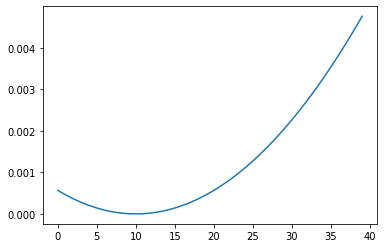

In [30]:
# Squared sinusoid (from Thompson and Hogg, 2017, JPO)
eastwestdivide = -50
taux_ref_east = 0.02
Ly = NJ # Domain width
Lr = 0 # Width of sponge region
Y0 = eastwestdivide
def double_sinusoid(x,Y0,Ly,Lr,ratio):
    y = ratio*np.sin(0.5*(x-Y0)/(Ly-Lr-Y0))**2
    return y
x = np.arange(-60,-20,1)
y = double_sinusoid(x,Y0,Ly,Lr,1)
plt.plot(y)

In [29]:
y = np.pi*(x-Y0)/(Ly-Lr-Y0)
y

array([-0.14959965, -0.13463969, -0.11967972, -0.10471976, -0.08975979,
       -0.07479983, -0.05983986, -0.0448799 , -0.02991993, -0.01495997,
        0.        ,  0.01495997,  0.02991993,  0.0448799 ,  0.05983986,
        0.07479983,  0.08975979,  0.10471976,  0.11967972,  0.13463969,
        0.14959965,  0.16455962,  0.17951958,  0.19447955,  0.20943951,
        0.22439948,  0.23935944,  0.25431941,  0.26927937,  0.28423934,
        0.2991993 ,  0.31415927,  0.32911923,  0.3440792 ,  0.35903916,
        0.37399913,  0.38895909,  0.40391906,  0.41887902,  0.43383899])

In [19]:
# Linear
tauxs = 0; # wind stress at the south
tauxn = 0.2; # wind stress at the north
tauy_ref = 0.0

A = (tauxs-tauxn)/(SOUTHLAT-(SOUTHLAT+LENLAT))
B = tauxs-A*SOUTHLAT
taux = A*Y+B
tauy = tauy_ref*np.ones(Y.shape)

In [20]:
# Save to forcing file
rootdir = '/work/gam/MOM6/forcing/'
config = 'channel'
filename = 'wind_uniform_1deg.nc'

with Dataset(rootdir+config+'/'+filename,'w') as d:
    d.createDimension('NI',NI)
    d.createDimension('NJ',NJ)
    d.createVariable('taux','f8',('NJ','NI'))[:]=taux
    d.createVariable('tauy','f8',('NJ','NI'))[:]=tauy